# Tadosking's Technical Anlysis Tools
- with this package, you can detect :
 - zigzag line
 - trend lines
 - channel lines

### Let's say, you have historical stock price data in 'Pandas DataFrame' type.
- i.e. 'yfinance' API provides easy way to get data in pandas.

In [1]:
import yfinance as yf

In [2]:
data = yf.Ticker('AAPL').history(start='2022-1-1')

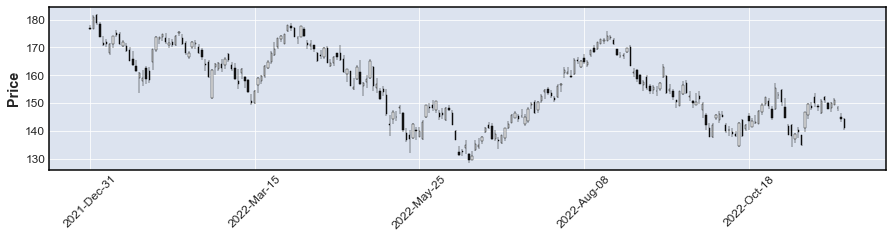

In [3]:
# plot it with mplfinance and matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

fig = mpf.figure(figsize=(15,3),style='default')
ax1 = fig.add_subplot(1,1,1)
mpf.plot(data,type='candle',ax=ax1)

### Extract high and low price data and convert them to 'DataPoints' objects

In [4]:
from TechnicalTools.DataOrganizer import Candles, DataPoints

In [5]:
candles = Candles.create_from_pandas(data)

dps_l = DataPoints.create_from_candles(candles,ohlcv='L')
dps_h = DataPoints.create_from_candles(candles,ohlcv='H')

### Sample datapoints for reducing size. 
- In this case, local min/max method (swing low/high method) is used.
- Change 'd'-value to obtain different detection results.

In [6]:
from TechnicalTools.DataSampler import LocalMinMaxSampler

In [7]:
d = 6
ll_dps_l = LocalMinMaxSampler(method='min',d=d).sample(dps_l)
ll_dps_h = LocalMinMaxSampler(method='max',d=d).sample(dps_h)

Text(0.5, 1.0, 'Local Min/Max Method')

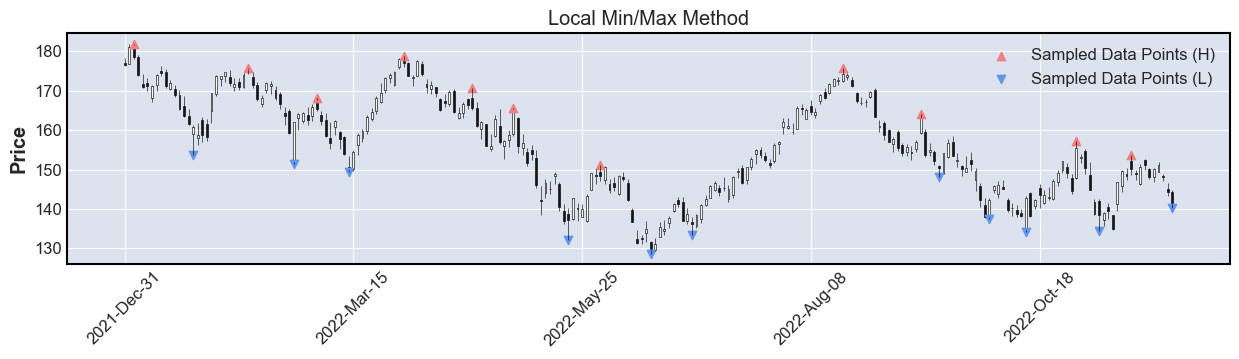

In [8]:
# plot
fig = mpf.figure(figsize=(15,3),style='default')
ax1 = fig.add_subplot(1,1,1)
mpf.plot(data,type='candle',ax=ax1)

ax1.scatter(ll_dps_h.xs, ll_dps_h.ys, marker='^', c='lightcoral', label='Sampled Data Points (H)')
ax1.scatter(ll_dps_l.xs, ll_dps_l.ys, marker='v', c='cornflowerblue', label='Sampled Data Points (L)')
ax1.legend()
ax1.set_title('Local Min/Max Method')

### Another option of sampling.
- Convexity method is used.
- Change 'w'-value to obtain different results.

In [9]:
from TechnicalTools.DataSampler import ConvexSampler

In [10]:
w = 20
cv_dps_l = ConvexSampler(target='downward',w=w).sample(dps_l)
cv_dps_h = ConvexSampler(target='upward'  ,w=w).sample(dps_h)

Text(0.5, 1.0, 'Convexity Method')

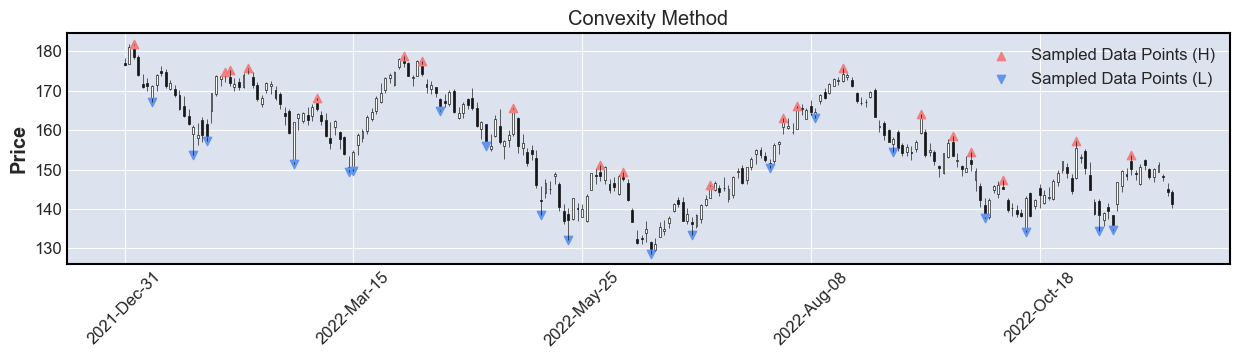

In [11]:
# plot
fig = mpf.figure(figsize=(15,3),style='default')
ax1 = fig.add_subplot(1,1,1)
mpf.plot(data,type='candle',ax=ax1)

ax1.scatter(cv_dps_h.xs, cv_dps_h.ys, marker='^', c='lightcoral', label='Sampled Data Points (H)')
ax1.scatter(cv_dps_l.xs, cv_dps_l.ys, marker='v', c='cornflowerblue', label='Sampled Data Points (L)')
ax1.legend()
ax1.set_title('Convexity Method')

### Concatenate high and low sampling data, and grouping it into chunks.

In [12]:
from TechnicalTools.Chunker import UpperLowerChunker

In [13]:
chunker = UpperLowerChunker(upper_symbol='H', lower_symbol='L')
chunks = chunker.chunk_down(cv_dps_h,cv_dps_l,
                            candles.extract_candles_by_index(cv_dps_h.indices).black_or_whites,
                            candles.extract_candles_by_index(cv_dps_l.indices).black_or_whites)

Text(0.5, 1.0, 'Each Chunk is Showed by Color and Marker')

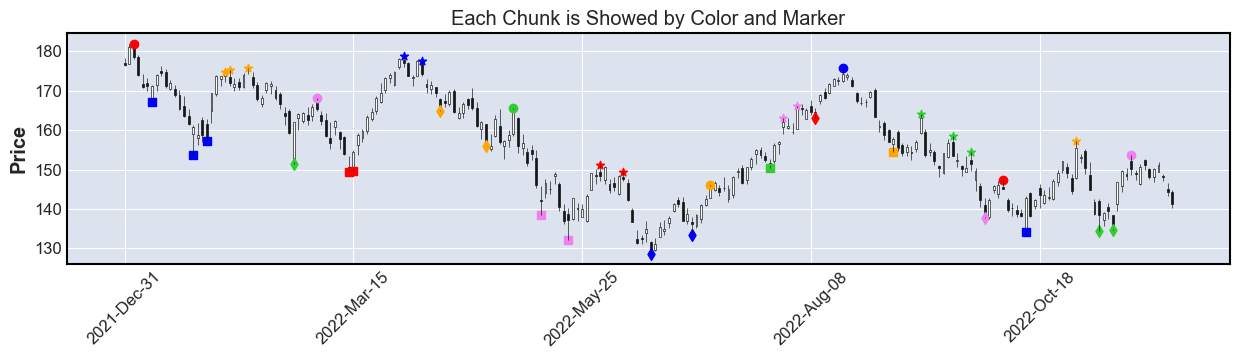

In [14]:
# plot
fig = mpf.figure(figsize=(15,3),style='default')
ax1 = fig.add_subplot(1,1,1)
mpf.plot(data,type='candle',ax=ax1)

import itertools
colors = itertools.cycle(['red','blue', 'orange', 'limegreen', 'violet'])
markers = itertools.cycle(['o',',','*','d'])

for chunk in chunks :
    dps = chunk.to_datapoints()
    ax1.scatter(dps.xs, dps.ys, c = next(colors), marker=next(markers))
    
ax1.set_title('Each Chunk is Showed by Color and Marker')

### Using chunks, let's detect zigzag line.
- each zigzag vertex is simply highest or lowest point in a chunk.

In [15]:
from TechnicalTools.ZigZag import ZigZagDetector

In [16]:
detector = ZigZagDetector(upper_symbol='H', lower_symbol='L')
zigzag = detector.detect_from_chunks(chunks)

In [17]:
ax1.plot(zigzag.xs, zigzag.ys, c='grey')
ax1.set_title('ZigZag')

Text(0.5, 1.0, 'ZigZag')

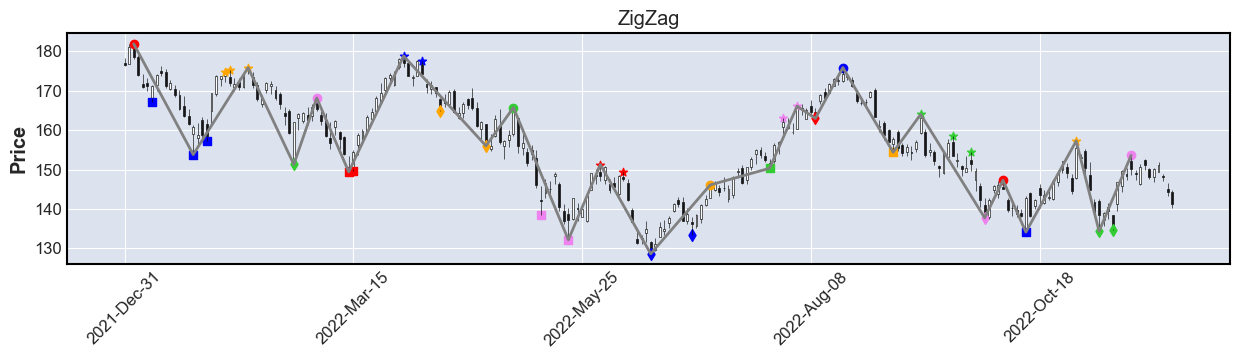

In [18]:
fig

### Now, let's detect trend lines
- detected trend lines have 'infos' variable in which you can find usefull infomation.

In [19]:
from TechnicalTools.TrendLine import TrendLineDetector

In [20]:
detector = TrendLineDetector(rs='R',max_window_size=5)
resistance_lines = detector.detect_from_chunks(chunks.get_chunks_by_symbol('H'))

detector = TrendLineDetector(rs='S',max_window_size=5)
support_lines = detector.detect_from_chunks(chunks.get_chunks_by_symbol('L'))

In [21]:
# variance of error
def calc_verr(l) :
    return l.infos['resid'] / (len(l.infos['datapoints'])-2)

Text(0.5, 1.0, 'Some Trend Lines Are Showed.')

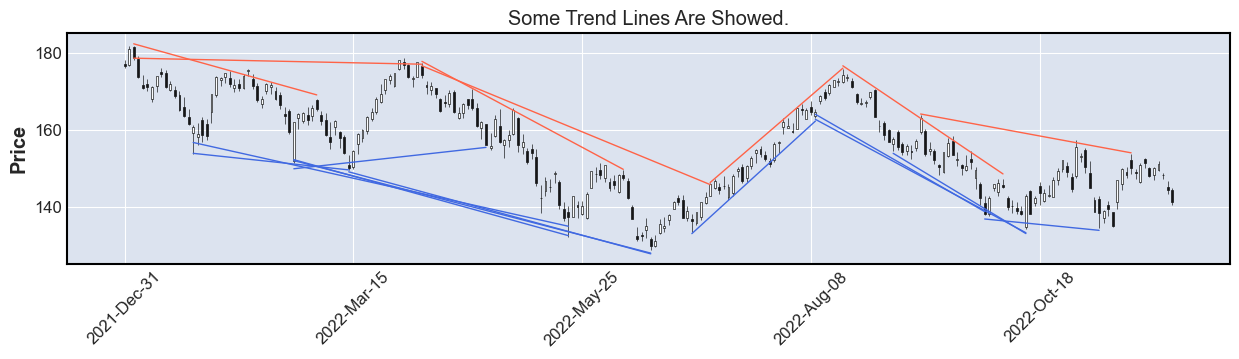

In [22]:
# plot
fig = mpf.figure(figsize=(15,3),style='default')
ax1 = fig.add_subplot(1,1,1)
mpf.plot(data,type='candle',ax=ax1)

threshold = 3

for l in support_lines :
    if calc_verr(l)**0.5 < threshold :
        ax1.plot(l.xs,l.ys, c= 'royalblue', linewidth=1 )
        
for l in resistance_lines :
    if calc_verr(l)**0.5 < threshold :
        ax1.plot(l.xs,l.ys, c='tomato', linewidth=1)
        
ax1.set_title('Some Trend Lines Are Showed.')

### Channel lines are also detectable.
- a channel line is composed of a pair of parallel support & resistance lines.

In [23]:
from TechnicalTools.TrendLine import ChannelLineDetector

In [24]:
detector = ChannelLineDetector(max_window_size=8)
channel_lines = detector.detect_from_chunks(chunks)
channel_lines.sort(key=lambda l : calc_verr(l))

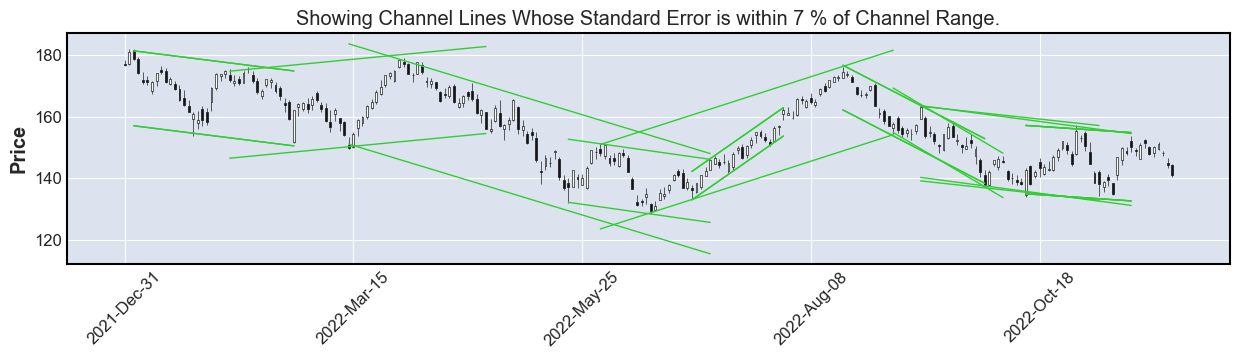

In [26]:
# plot
fig = mpf.figure(figsize=(15,3),style='default')
ax1 = fig.add_subplot(1,1,1)
mpf.plot(data,type='candle',ax=ax1)

threshold = 0.07 # 7%
ax1.set_title('Showing Channel Lines Whose Standard Error is within 7 % of Channel Range.')

for l in channel_lines :
    if (calc_verr(l)**0.5)/l.infos['channel_range'] < threshold :
        rl = l.resistance_line
        sl = l.support_line
        ax1.plot(rl.xs,rl.ys, c='limegreen', linewidth=1 )
        ax1.plot(sl.xs,sl.ys, c='limegreen', linewidth=1 )
        
